<a href="https://colab.research.google.com/github/ManojKesani/knowledge_distill_image_retrival/blob/main/knowledge_distill_image_retrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly

In [ ]:
!unzip /content/drive/MyDrive/datasets/image_retrieval.zip -d/content/data

In [148]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import decode_predictions,preprocess_input

import glob


In [ ]:
model = tf.keras.applications.EfficientNetB7(weights='imagenet' ,include_top=True,classifier_activation=None)


In [ ]:
import pandas as pd

col_names = ['image_path','teacher_logits','label']
df = pd.DataFrame(columns=col_names)
# i = 0
for idx,path in enumerate(glob.iglob(r'/content/data/dataset/*.jpg')) :
  print(idx)

  # if idx > 5:
  #   break
  
  img = image.load_img(path,target_size=(600,600))
  x =img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)

  df.loc[idx] = [path,preds[0],decode_predictions(preds, top=1)[0][0][1]]
# print(i)

In [ ]:
df

In [ ]:
df[df['image_path']=='/content/data/dataset/407.jpg']

In [ ]:
import collections
a = df['label'].tolist()

counter=collections.Counter(a)
print(counter)

In [8]:
new_df = pd.DataFrame(columns=col_names)
i = 0
for idx,row in df.iterrows():
  label = row['label']
  
  if counter[label] >100:
    # print(type(row))
    new_df.loc[i] = row
    i += 1

 

In [ ]:
# new_df.to_csv('teacher_logits_data.csv')
for idx,row in new_df.iterrows():
  if idx<5:
    print(row)

In [10]:
import collections
a = new_df['label'].tolist()

counter=collections.Counter(a)

name = []
count = []

for key in counter.keys():
  name.append(key)
  count.append(counter[key])

In [ ]:
counter

In [ ]:
import matplotlib.pyplot as plt

plt.barh(name,count)

In [ ]:
name

In [14]:
onehot_list = []
for l in new_df['label'].tolist():
  onehot = np.zeros(len(name))
  idx = name.index(l)
  onehot[idx] = 1
  onehot_list.append(onehot)


In [15]:
label_int = []
for l in new_df['label'].tolist():
  idx = name.index(l)
  label_int.append(idx)

In [16]:
new_df['label_onehot'] = onehot_list
new_df['label_int'] = label_int


In [ ]:
new_df

In [17]:
new_df.to_csv('eff-net-d7_teacher_logits.csv')

In [149]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D ,Flatten ,Reshape,Activation,BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,add,UpSampling2D

from keras.callbacks import TensorBoard
from keras.models import Model ,load_model
from keras.utils import Sequence
from keras.utils import plot_model
from keras import backend as K
from keras import preprocessing


from IPython.display import Image

from skimage.io import imread
from skimage import io

import random


In [470]:
class DataGenerator(Sequence):
  def __init__(self, path_list,teacher_logits,labels, batch_size, flip = True):
    self.path_list = path_list
    self.batch_size = batch_size
    self.flip = flip
    self.logits = teacher_logits
    self.labels = labels

  def __len__(self):
    return int(np.floor(len(self.path_list) / self.batch_size))

  def __getitem__(self,index):
    # print('working on batch ',index)
    paths = self.path_list[index*self.batch_size:(index+1)*self.batch_size]
    logit = self.logits[index*self.batch_size:(index+1)*self.batch_size]
    label = self.labels[index*self.batch_size:(index+1)*self.batch_size]

    x = np.empty((batch_size, 512, 512, 3), dtype=np.float32)
    t = np.empty((batch_size,1000))
    l = np.empty((batch_size,1))
    for idx, data in enumerate(zip(paths,logit,label)):
      t[idx] =  data[1]
      l[idx] = data[2]
      # flip image
      if random.random()<0.5:
        x[idx] = np.fliplr(imread(data[0]).astype('float32')/255.)        
      else:
        x[idx] = imread(data[0]).astype('float32')/255.


    return [x , t , l , paths]
    # return x , t , l 
 


In [471]:
path_list = new_df['image_path'].tolist()
teacher_logits = new_df['teacher_logits'].tolist()
OH_labels = new_df['label_onehot'].tolist()
labels = new_df['label_int'].tolist()


In [472]:
train_path_list=path_list[:4000]
train_teacher_logits=teacher_logits[:4000]
train_OH_labels=OH_labels[:4000]
train_labels=labels[:4000]


validation_path_list=path_list[4000:]
validation_teacher_logits=teacher_logits[4000:]
validation_OH_labels=OH_labels[4000:]
validation_labels=labels[4000:]

In [473]:
batch_size = 32
train_data = DataGenerator(train_path_list,train_teacher_logits,train_labels, batch_size)
validation_data = DataGenerator(validation_path_list,validation_teacher_logits,validation_labels, batch_size)

In [466]:
a = next(iter(validation_data))

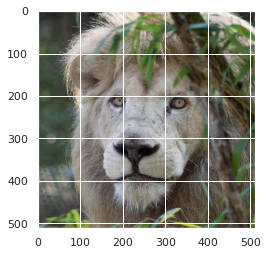

In [467]:
img = a[0][2]
plt.imshow(img)

In [448]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def dense(nodes,activation = 'relu'):
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Dense(nodes,activation=activation)
  )

  return result

def convo1d(filters,activation = 'relu'):
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv1D(filters,1,activation=activation)
  )

  return result


In [449]:
def unet_like():
  inputs = tf.keras.layers.Input(shape=[512,512,3])

  down_stack = [
    downsample(32, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(32, 4), # (bs, 64, 64, 128)?
    downsample(64, 4), # (bs, 32, 32, 256)?
    downsample(64, 4), # (bs, 16, 16, 512)?
    downsample(128, 4), # (bs, 8, 8, 512)?
    downsample(128, 4), # (bs, 4, 4, 512)?
    downsample(256, 4), # (bs, 2, 2, 512)?
    downsample(256, 4), # (bs, 1, 1, 512)?
  ]

  up_stack = [
    upsample(256, 4, apply_dropout=True), # (bs, 2, 2, 1024)?
    upsample(256, 4, apply_dropout=True), # (bs, 4, 4, 1024)?
    upsample(128, 4, apply_dropout=True), # (bs, 8, 8, 1024)?
    upsample(64, 4), # (bs, 16, 16, 1024)?
    upsample(32, 4), # (bs, 32, 32, 512)?
    upsample(16, 4), # (bs, 64, 64, 256)?
    upsample(16, 4), # (bs, 128, 128, 128)?
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid') # (bs, 512, 512, 3)
  print('hi')

  x = inputs

  # Downsampling through the model
  skips = []
  for idx,down in enumerate(down_stack):
    x = down(x)
    skips.append(x)

    #attach student
    # if idx == len(down_stack)-2:
    #   s1 = x

  skips = reversed(skips[:-1])

  shape_before_flattening = K.int_shape(x)

  x = Flatten()(x)

  encode = dense(1024)(x)
  x = Reshape(shape_before_flattening[1:])(encode)



  # Upsampling and establishing the skip connections
  for idx,(up, skip) in enumerate(zip(up_stack, skips)):
    
    #attach student
    if idx == 3:
      s1 = x
      # break

    x = up(x)
    if idx<3:
      # x = tf.keras.layers.Concatenate()([x, skip])
      pass

    
    

  x = last(x)

  #student stuff

  # # s2 = tf.keras.layers.Flatten()(s1)
  # # sx1 = dense(1024)(s2)
  # # sx2 = dense(1000,activation=None)(sx1)

  # s2 = tf.keras.layers.Flatten()(s1)
  # sx2 = dense(1000,activation=None)(s2)  #38,706,027 good at 30 epochs

  s2 = downsample(32, 4)(s1)
  s3 = downsample(16, 4)(s2)
  s4 = tf.keras.layers.Flatten()(s3)
  sx2 = dense(1000,activation=None)(s4)     #6,267,947






  return tf.keras.Model(inputs=inputs, outputs=[x,sx2,encode])

In [ ]:
model = unet_like()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.summary()

#test

In [ ]:
# def unet_like(input_size=(512,512,3)):
#     inputs = Input(input_size)
    
#     conv1 = Conv2D(32, (3, 3), padding='same',activation='relu')(inputs)
#     conv1 = Conv2D(32, (3, 3), padding='same',activation='relu')(conv1)
#     bn1 = BatchNormalization(axis=3)(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

#     conv2 = Conv2D(64, (3, 3), padding='same',activation='relu')(pool1)
#     conv2 = Conv2D(64, (3, 3), padding='same',activation='relu')(conv2)
#     bn2 = BatchNormalization(axis=3)(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

#     conv3 = Conv2D(128, (3, 3), padding='same',activation='relu')(pool2)
#     conv3 = Conv2D(128, (3, 3), padding='same',activation='relu')(conv3)
#     bn3 = BatchNormalization(axis=3)(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

#     conv4 = Conv2D(256, (3, 3), padding='same',activation='relu')(pool3)
#     conv4 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv4)
#     bn4 = BatchNormalization(axis=3)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

#     conv5 = Conv2D(256, (3, 3), padding='same',activation='relu')(pool4)
#     conv5 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv5)
#     bn5 = BatchNormalization(axis=3)(conv5)

#     #student
#     s1 = Conv2D(256, (3, 3), padding='same',activation='relu')(bn5)
#     s2 = Conv2D(128, (3, 3), padding='same',activation='relu')(s1)
#     x = Flatten()(s2)

#     d1 = Dense(1000,activation='relu')



#     up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
#     conv6 = Conv2D(512, (3, 3), padding='same',activation='relu')(up6)
#     conv6 = Conv2D(512, (3, 3), padding='same',activation='relu')(conv6)
#     bn6 = BatchNormalization(axis=3)(conv6)

#     up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
#     conv7 = Conv2D(256, (3, 3), padding='same',activation='relu')(up7)
#     conv7 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv7)
#     bn7 = BatchNormalization(axis=3)(conv7)

#     up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
#     conv8 = Conv2D(128, (3, 3), padding='same',activation='relu')(up8)
#     conv8 = Conv2D(128, (3, 3), padding='same',activation='relu')(conv8)
#     bn8 = BatchNormalization(axis=3)(conv8)

#     up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
#     conv9 = Conv2D(64, (3, 3), padding='same',activation='relu')(up9)
#     conv9 = Conv2D(64, (3, 3), padding='same',activation='relu')(conv9)
#     bn9 = BatchNormalization(axis=3)(conv9)

#     conv10 = Conv2D(3, (1, 1), activation='sigmoid')(bn9)

#     return Model(inputs=[inputs], outputs=[conv10,d1])



# model = unet_like()
# model.summary()


In [ ]:
# from tensorflow.keras import layers
# class unet_like(layers.Layer):
#   def __init__(self):
#     super(unet_like,self).__init__()
#     # self.input_shape = input_shape

#   def call(self,inputs):
#     inputs = Input(input = inputs)
    
#     conv1 = Conv2D(32, (3, 3), padding='same',activation='relu')(inputs)
#     conv1 = Conv2D(32, (3, 3), padding='same',activation='relu')(conv1)
#     bn1 = BatchNormalization(axis=3)(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

#     conv2 = Conv2D(64, (3, 3), padding='same',activation='relu')(pool1)
#     conv2 = Conv2D(64, (3, 3), padding='same',activation='relu')(conv2)
#     bn2 = BatchNormalization(axis=3)(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

#     conv3 = Conv2D(128, (3, 3), padding='same',activation='relu')(pool2)
#     conv3 = Conv2D(128, (3, 3), padding='same',activation='relu')(conv3)
#     bn3 = BatchNormalization(axis=3)(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

#     conv4 = Conv2D(256, (3, 3), padding='same',activation='relu')(pool3)
#     conv4 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv4)
#     bn4 = BatchNormalization(axis=3)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

#     conv5 = Conv2D(256, (3, 3), padding='same',activation='relu')(pool4)
#     conv5 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv5)
#     bn5 = BatchNormalization(axis=3)(conv5)

#     #student
#     s1 = Conv2D(256, (3, 3), padding='same',activation='relu')(bn5)
#     s2 = Conv2D(128, (3, 3), padding='same',activation='relu')(s1)
#     x = Flatten()(s2)

#     d1 = Dense(1000,activation='relu')



#     up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
#     conv6 = Conv2D(512, (3, 3), padding='same',activation='relu')(up6)
#     conv6 = Conv2D(512, (3, 3), padding='same',activation='relu')(conv6)
#     bn6 = BatchNormalization(axis=3)(conv6)

#     up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
#     conv7 = Conv2D(256, (3, 3), padding='same',activation='relu')(up7)
#     conv7 = Conv2D(256, (3, 3), padding='same',activation='relu')(conv7)
#     bn7 = BatchNormalization(axis=3)(conv7)

#     up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
#     conv8 = Conv2D(128, (3, 3), padding='same',activation='relu')(up8)
#     conv8 = Conv2D(128, (3, 3), padding='same',activation='relu')(conv8)
#     bn8 = BatchNormalization(axis=3)(conv8)

#     up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
#     conv9 = Conv2D(64, (3, 3), padding='same',activation='relu')(up9)
#     conv9 = Conv2D(64, (3, 3), padding='same',activation='relu')(conv9)
#     bn9 = BatchNormalization(axis=3)(conv9)

#     conv10 = Conv2D(3, (1, 1), activation='sigmoid')(bn9)

#     return conv10,d1



# model = unet_like()
# # model.summary()


In [ ]:
batch_size = 64
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

#Models

In [451]:
import keras
class Distiller(keras.Model):
    def __init__(self, model):
        super(Distiller, self).__init__()
        self.model = model
        # self.student = student

    def call(self,input_tensor,training=False):
      return self.model(input_tensor,training = training)


    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x = data[0]
        t =data[1]
        y = data[2]
        # Forward pass of teacher
        teacher_predictions = t

        with tf.GradientTape() as tape:
            # Forward pass of student
            reconstruction,student_predictions,_ = self.model(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            s_loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)))/(512*512*3)

            loss = 0.5*(s_loss + reconstruction_loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        # results.update(
        #     {"student_loss": student_loss, "distillation_loss": distillation_loss}
        # )
        results.update(
            {"student_loss": s_loss, "distillation_loss": reconstruction_loss} # needs changes just printing rec loss, todo add a metric in compile
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x = data[0]
        t =data[1]
        y = data[2]

        # Compute predictions
        reconstruction,y_prediction,_ = self.model(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
# Initialize and compile distiller
distiller = Distiller(model = model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_data,epochs=15,validation_data=validation_data,callbacks=[TensorBoard(log_dir='/content/output')])
# distiller.fit(train_data,epochs=2)

# Evaluate student on test dataset
# distiller.evaluate(x_test, y_test)


In [ ]:
# !rm -r /content/output

%load_ext tensorboard
%tensorboard --logdir /content/output

In [468]:
a,_,_ = next(iter(validation_data))
out = distiller.predict(a)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


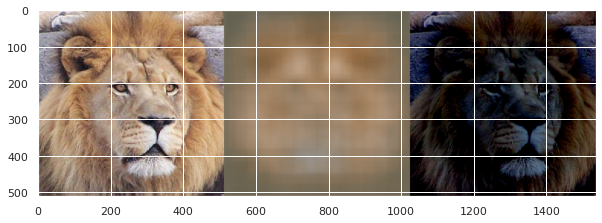

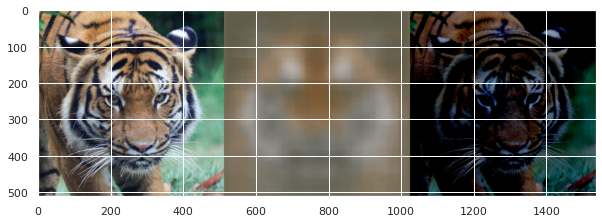

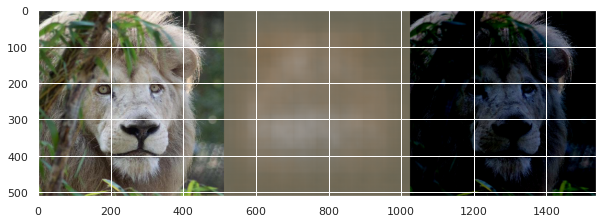

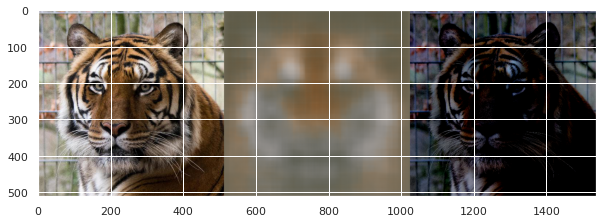

In [504]:
for i in range(out[0].shape[0]):
  if i>3:
    break
  plt.figure(figsize=(10,10))
  image = np.hstack((a[i],out[0][i],a[i]-out[0][i]))
  plt.imshow(image)


In [474]:
train_path_list=path_list[:4000]
train_teacher_logits=teacher_logits[:4000]
train_OH_labels=OH_labels[:4000]
train_labels=labels[:4000]

validation_path_list=path_list[4000:]
validation_teacher_logits=teacher_logits[4000:]
validation_OH_labels=OH_labels[4000:]
validation_labels=labels[4000:]

In [475]:
output_df = pd.DataFrame(columns=['image_path','encoding','label','train/test'])

for data in train_data:

  images,_,labels,paths = data
  _,_,encodings = distiller.predict(images)

  for idx,encode in enumerate(encodings):
    output_df = output_df.append({'image_path':paths[idx],
                                  'encoding':encode,
                                  'label':labels[idx],
                                  'train/test':'train'},ignore_index=True)

  # print(encode.shape)


In [476]:
# validation_data
for data in validation_data:

  images,_,labels,paths = data
  _,_,encodings = distiller.predict(images)

  for idx,encode in enumerate(encodings):
    # print(encode.shape)
    output_df = output_df.append({'image_path':paths[idx],
                                  'encoding':encode,
                                  'label':labels[idx],
                                  'train/test':'test'},ignore_index=True)


In [477]:
data_t = np.zeros((4000,1024))
l_t = np.zeros((4000,1))

data_v = np.zeros((512,1024))
l_v = np.zeros((512,1))

In [478]:
train_encoded_data = output_df[output_df['train/test']=='train']['encoding']
train_lb = output_df[output_df['train/test']=='train']['label']


val_encoded_data = output_df[output_df['train/test']=='test']['encoding']
val_lb = output_df[output_df['train/test']=='test']['label']

In [ ]:
len(val_lb)

In [480]:
for idx, row in enumerate(train_encoded_data.iteritems()):
  data_t[idx] = np.array(row[1])

for idx, row in enumerate(train_lb.iteritems()):
  l_t[idx] = np.array(row[1])

for idx, row in enumerate(val_encoded_data.iteritems()):
  data_v[idx] = np.array(row[1])

for idx, row in enumerate(val_lb.iteritems()):
  l_v[idx] = np.array(row[1])

In [481]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', random_state=0)
proj_t = tsne.fit_transform(data_t)

tsne = TSNE(n_components=2, init='random', random_state=0)
proj_v = tsne.fit_transform(data_v)



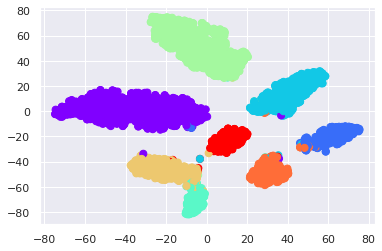

In [482]:
plt.scatter(proj_t[:, 0], proj_t[:, 1], c=l_t, s=50, cmap='rainbow');

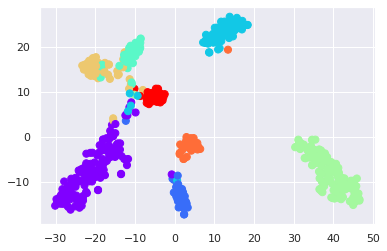

In [483]:
plt.scatter(proj_v[:, 0], proj_v[:, 1], c=l_v, s=50, cmap='rainbow');

In [ ]:
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans 


distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
Kk = range(1,20) 
  
for k in Kk:
  print(k)
  #Building and fitting the model 
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(data_t)     
      
  distortions.append(sum(np.min(cdist(data_t, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / data_t.shape[0]) 
  inertias.append(kmeanModel.inertia_) 
  
  mapping1[k] = sum(np.min(cdist(data_t, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / data_t.shape[0] 
  mapping2[k] = kmeanModel.inertia_ 

# for key,val in mapping1.items(): 
#     print(str(key)+' : '+str(val)) 

plt.plot(Kk, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


In [ ]:
kmeanModel_AE = KMeans(n_clusters=8)
kmeanModel_AE.fit(data_t)

In [487]:
# cluster numbers for training data
x_kmeans_AE = kmeanModel_AE.predict(data_t)

# cluster numbers for val data
y_kmeans_AE = kmeanModel_AE.predict(data_v)

In [488]:
dataset_paths = output_df['image_path'].tolist()
t_path = dataset_paths[:4000]
v_path = dataset_paths[4000:]

db_cluster_path_list = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
db_cluster_labels = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
db_cluster_encoded = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}

q_cluster_path_list = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
q_cluster_labels = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
q_cluster_encoded = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}


for idx , cluster_number in enumerate(x_kmeans_AE):
  db_cluster_path_list[cluster_number].append(t_path[idx])
  db_cluster_labels[cluster_number].append(name[int(l_t[idx])])
  db_cluster_encoded[cluster_number].append(data_t[idx])


for idx , cluster_number in enumerate(y_kmeans_AE):
  q_cluster_path_list[cluster_number].append(v_path[idx])
  q_cluster_labels[cluster_number].append(name[int(l_v[idx])])
  q_cluster_encoded[cluster_number].append(data_v[idx])

In [ ]:
q_cluster_labels

In [ ]:
num = 5
i = 0
for path in db_cluster_path_list[num]:
  i+=1
  if i>10:
    break

  img = imread(path)
  
  plt.figure(figsize=(5,5))
  plt.imshow(img)


In [496]:
for i in range(8):
  print('images in cluster {}'.format(i), len(db_cluster_path_list[i]))

images in cluster 0 284
images in cluster 1 1052
images in cluster 2 549
images in cluster 3 497
images in cluster 4 283
images in cluster 5 788
images in cluster 6 361
images in cluster 7 186


In [519]:
cluster_num = 0
img_num = 13

results = []
q_encode = q_cluster_encoded[cluster_num][img_num]
q_path = q_cluster_path_list[cluster_num][img_num]

for db_encode,path in zip(db_cluster_encoded[cluster_num],db_cluster_path_list[cluster_num]):

  d = np.linalg.norm(q_encode - db_encode)
  results.append((d,path))

sorted_res = sorted(results)[:25]

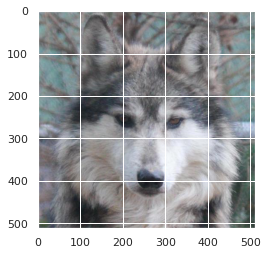

In [520]:
q_img = imread(q_path)
plt.imshow(q_img)

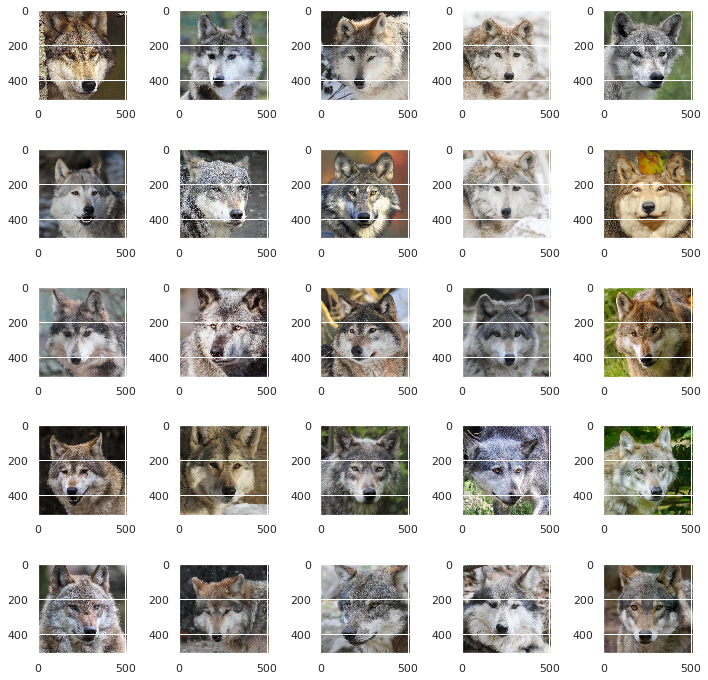

In [521]:
plt.figure(figsize=(10,10))
for idx , (_,path) in enumerate(sorted_res):
  image = imread(path)
  plt.subplot(5,5,idx+1)
  io.imshow(image)

plt.show()